# Восстановление золота из руды

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используем данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обратимся к библиотекам *pandas*, *matplotlib* и *sklearn.*

## Подготовка данных

### Откройте файлы и изучите их.

In [17]:
#Импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st

#хитмэп корреляции
import os
import seaborn as sns

#операции с выборкой
from sklearn.model_selection import train_test_split

#сохранение модели
import joblib 
from joblib import dump

#классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor #создание конст модели: среднее, медиана и др

#преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score #кросс-валидация
from sklearn.metrics import make_scorer #для написания ручной оценки

#подбор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#построение ROC-кривой
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
#построение графиков
import seaborn as sns

#раздел upsampling
from sklearn.utils import shuffle

In [18]:
#Уберем предупреждения и ограничения:

#D:\installed\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.if _joblib.__version__ >= LooseVersion('0.12'):
import warnings
warnings.filterwarnings('ignore')

#SettingWithCopy 
#при записи изменённых признаков в исходный датафрейм (особенности поведения sklearn и pandas)
pd.options.mode.chained_assignment = None

#отключим предупреждением библиотеки sklearn при обучении логистической регрессии, 
#укажем аргумент solver='liblinear' (англ. solver «алгоритм решения»; library linear, «библиотека линейных алгоритмов»)

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [19]:
#загрузим датасет
try:
    df_full = pd.read_csv('gold_recovery_full_new.csv')
    df_test = pd.read_csv('gold_recovery_test_new.csv')
    df_train = pd.read_csv('gold_recovery_train_new.csv')
    
    df_full_raw = pd.read_csv('gold_recovery_full_new.csv')
    df_test_raw = pd.read_csv('gold_recovery_test_new.csv')
    df_train_raw = pd.read_csv('gold_recovery_train_new.csv')
    
    
except FileNotFoundError:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    
    df_full_raw = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_test_raw = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_train_raw = pd.read_csv('/datasets/gold_recovery_train_new.csv')

#### Рассмотрим данные

In [20]:
#рассмотрим данные
for df in [df_full, df_test, df_train]:
    print('датасет:')
    #print(df.dtypes)
    #display(df.head(10)) 
    display(df.head())
    #df.describe()
    df.info()
    print()

датасет:


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


### Проверим, что эффективность обогащения рассчитана правильно. 
    -Вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery. 
    -Найдем MAE между нашими расчётами и значением признака. 
    -Опишем выводы.
    
    Дано:
    выборка: df_train
    этап: флотация = rougher
    Вычислим: rougher.output.recovery
    Cоставляющие для формулы:
    1) C — доля золота в концентрате после флотации/очистки = rougher.output.concentrate_au
    2) F — доля золота в сырье/концентрате до флотации/очистки = rougher.input.feed_au 
    3) T — доля золота в отвальных хвостах после флотации/очистки = rougher.output.tail_au 

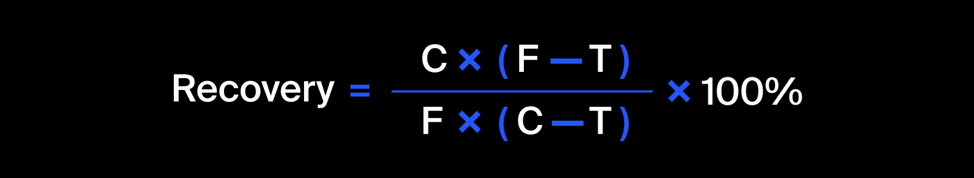

In [22]:
#добавим расчетный столбец 
df_train['rougher.output.recovery_calculation'] = df_train['rougher.output.recovery']

#внесем данные в расчетный столбец согласно формуле
df_train['rougher.output.recovery_calculation'] = (  
    (df_train['rougher.output.concentrate_au']*(df_train['rougher.input.feed_au']-df_train['rougher.output.tail_au'])) / (
        df_train['rougher.input.feed_au']*(df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au']))  )*100

In [23]:
#проверим что столбец добавился, данные в нем есть:
df_train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_calculation
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,1

In [24]:
#рассчитаем отклонение между рассчитанными данными 
#и данными исходного датасета (rougher.output.recovery_calculation и rougher.output.recovery)

mse = mean_squared_error(df_train['rougher.output.recovery'], df_train['rougher.output.recovery_calculation'])
print("RMSE =", mse ** 0.5)

#вычислим отклонение в процентах от среднего значения признака чтобы понимать масштаб отклонения
print('rmse_proc', (mse ** 0.5 / df_train['rougher.output.recovery'].mean()*100), '%')

RMSE = 1.475796882318574e-14
rmse_proc 1.7844214679441462e-14 %


### Проанализируем признаки, недоступные в тестовой выборке. 
    Определим какие это параметры
    Определим к какому типу они относятся

In [25]:
columns_train = list(df_train.columns) # получим список столбцов датасета с бОльшим количеством признаков
columns_test = list(df_test.columns) # получим список столбцов датасета с меньшим количеством признаков

# выведем каких столбцов нет в первом датасете
different_columns = []
for column in columns_train:
    if column not in columns_test:
        if column != 'rougher.output.recovery': #оставим один признак который пригодится в пункте 3 в подпункте "Сделаем таргет и признаки для обучения модели на трейн выборке"
            different_columns.append(column)

display(len(different_columns))
display('признаки, недоступные в тестовой выборке:', different_columns)
display(df_train.dtypes)

34

'признаки, недоступные в тестовой выборке:'

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.ta

date                                                   object
final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.input.sulfate                         float64
primary_cleaner.input.depressant                      float64
primary_cleaner.input.feed_size                       float64
primary_cleaner.input.xanthate                        float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_

### *Проведем предобработку данных.

In [26]:
print('df_full', df_full.shape)
df_full = df_full.dropna()
df_full = df_full.drop(['date'], axis=1) #удалим неважный для обучения столбец даты
print('df_full', df_full.shape)

print('df_test', df_test.shape)
df_test = df_test.dropna()
df_test = df_test.drop(['date'], axis=1) #удалим неважный для обучения столбец даты
print('df_test', df_test.shape)

df_full (19439, 87)
df_full (16094, 86)
df_test (5290, 53)
df_test (5229, 52)


### Вывод
    -открыли и изучили файлы
    
    -проверили, что эффективность обогащения рассчитана правильно:
    RMSE = 1.475796882318574e-14
    отклонение в процентах от среднего значения признака чтобы понимать масштаб отклонения rmse_proc:
    1.7844214679441516e-14 %
    Точность на грани вычислительной способности/разрядности.
    
    -определили признаки, недоступные в тестовой выборке, сохранили и вывели их список
    -один из отсутствующих признаков, важный в данной работе -rougher.output.recovery

## Анализ данных

### *Проверим как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [28]:
#выберем необходимые признаки/столбцы согласно условию пункта

columns_train = list(df_train.columns)

columns_train_concentrate = []
for column in columns_train:
    if ('concentrate_au' in column) or ('concentrate_ag' in column) or ('concentrate_pb' in column):
        columns_train_concentrate.append(column)

display(len(columns_train_concentrate))
display(columns_train_concentrate)

9

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au']

In [29]:
df_full[df_full['rougher.output.concentrate_au']>0].sum()

final.output.concentrate_ag                           8.214075e+04
final.output.concentrate_pb                           1.579374e+05
final.output.concentrate_sol                          1.561556e+05
final.output.concentrate_au                           6.994366e+05
final.output.recovery                                 1.067467e+06
final.output.tail_ag                                  1.546470e+05
final.output.tail_pb                                  4.363441e+04
final.output.tail_sol                                 1.727875e+05
final.output.tail_au                                  4.923585e+04
primary_cleaner.input.sulfate                         2.412117e+06
primary_cleaner.input.depressant                      1.444892e+05
primary_cleaner.input.feed_size                       1.162974e+05
primary_cleaner.input.xanthate                        1.666498e+04
primary_cleaner.output.concentrate_ag                 1.372524e+05
primary_cleaner.output.concentrate_pb                 1.558692

In [ ]:
print(df_full.query('rougher.output.concentrate_au > 0'))

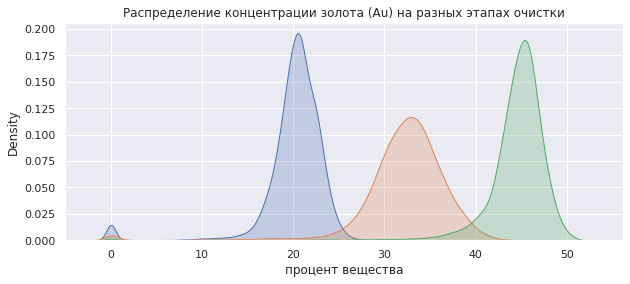

In [31]:
sns.set(rc={'figure.figsize':(10,4)})
ax = sns.kdeplot(df_full['rougher.output.concentrate_au'], shade=True, label='Флотация' )
ax = sns.kdeplot(df_full['primary_cleaner.output.concentrate_au'], shade=True, label='Первичная очистка' )
ax = sns.kdeplot(df_full['final.output.concentrate_au'], shade=True, label='Финальный продукт' )
plt.title('Распределение концентрации золота (Au) на разных этапах очистки')
plt.xlabel('процент вещества');

Видно, что золото растёт.. Серебро падает - это логично, тк производим золото.
А свинец - побочный элемент химических реакций, поэтому увеличивается его содержание.

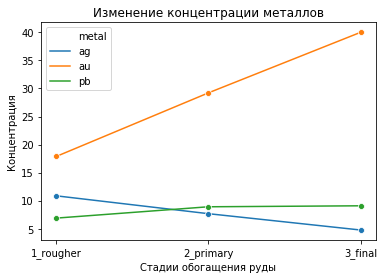

### *Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 
    Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

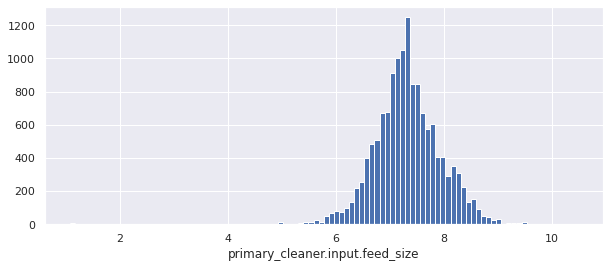

среднее значение признака: primary_cleaner.input.feed_size 7.322309906901314
медианное значение признака: primary_cleaner.input.feed_size 7.289999961853027


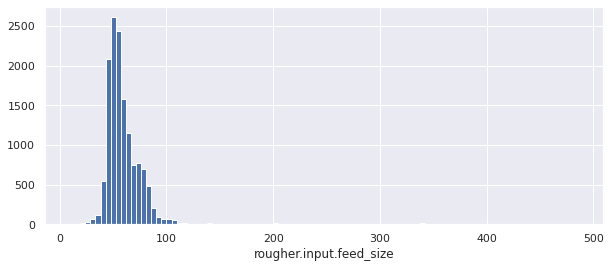

среднее значение признака: rougher.input.feed_size 60.11051805066844
медианное значение признака: rougher.input.feed_size 55.37388507888542


In [33]:
#выберем необходимые признаки/столбцы согласно условию пункта
columns_train = list(df_train.columns)

columns_train_feed_size = []
for column in columns_train:
    if ('feed_size' in column):
        columns_train_feed_size.append(column)

for column in columns_train_feed_size:
    plt.figure()
    plt.xlabel(column)
    df_train[column].hist(bins=100)
    plt.show()
    
    print('среднее значение признака:', column, df_train[column].mean())
    print('медианное значение признака:', column, df_train[column].median())

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

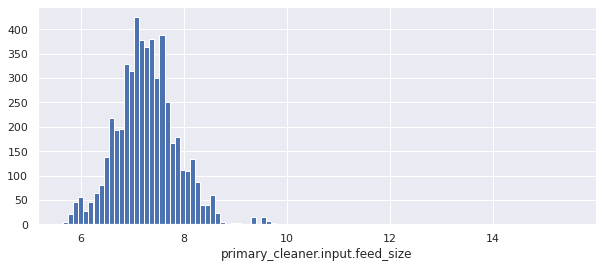

среднее значение признака: primary_cleaner.input.feed_size 7.271545576079371
медианное значение признака: primary_cleaner.input.feed_size 7.25


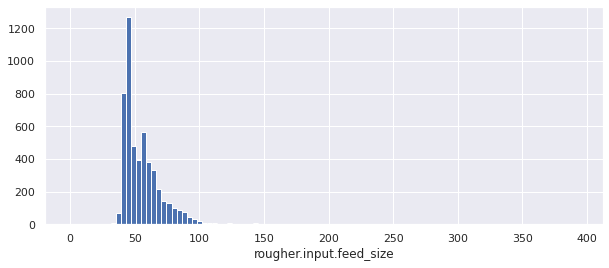

среднее значение признака: rougher.input.feed_size 55.86397810255099
медианное значение признака: rougher.input.feed_size 50.77272939330314


In [34]:
#выберем необходимые признаки/столбцы согласно условию пункта
columns_test = list(df_test.columns)

columns_test_feed_size = []
for column in columns_test:
    if ('feed_size' in column):
        columns_test_feed_size.append(column)
display(columns_test_feed_size)

for column in columns_test_feed_size:
    plt.figure()
    plt.xlabel(column)
    df_test[column].hist(bins=100)
    plt.show()
    
    print('среднее значение признака:', column, df_test[column].mean())
    print('медианное значение признака:', column, df_test[column].median())

Распределение для тестовой выборки отличается от такового для обучающей - первое сдвинуто немного в меньшую сторону. НО в целом размеры большинства частиц лежат в оптимальном интервале  40—100 мкм  («Флотация руды»: ООО "Техноаналитприбор":[сайт].URL:https://techade.ru/stati/flotatsiya-rudy) для обоих выборок. Поэтому выборки подходят для оценки.

### Исследуем суммарную концентрацию всех веществ на разных стадиях: 
    в сырье, 
    в черновом 
    и финальном концентратах

In [35]:
for column in ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'final.output.concentrate_au']:
    print('суммарная концентрация вещества на этапе:', column, df_train[column].sum())  

суммарная концентрация вещества на этапе: rougher.input.feed_au 111304.19573631769
суммарная концентрация вещества на этапе: rougher.output.concentrate_au 275055.9636399745
суммарная концентрация вещества на этапе: final.output.concentrate_au 622609.6476463173


In [36]:
for column in ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'final.output.concentrate_ag']:
    print('суммарная концентрация вещества на этапе:', column, df_train[column].sum())  

суммарная концентрация вещества на этапе: rougher.input.feed_ag 121387.03283664072
суммарная концентрация вещества на этапе: rougher.output.concentrate_ag 166615.96843582357
суммарная концентрация вещества на этапе: final.output.concentrate_ag 72749.49202790101


In [37]:
for column in ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'final.output.concentrate_pb']:
    print('суммарная концентрация вещества на этапе:', column, df_train[column].sum())

суммарная концентрация вещества на этапе: rougher.input.feed_pb 49491.50952515511
суммарная концентрация вещества на этапе: rougher.output.concentrate_pb 108445.7851787124
суммарная концентрация вещества на этапе: final.output.concentrate_pb 143361.1133262377


### !Вывод
    -концентрация веществ при прохождении стадий очистки изменяется в среднем следующим образом (%):
    --au увеличивается с 20 до 45
    --ag уменьшается от 11 до 5
    --pb увеличивается от 8 до 11
    
    -распределения размеров гранул сырья на обучающей и тестовой выборках - внешне по гистограммам и по значениям имеют отличия:
    -На обучающей выборке:
    --среднее значение признака: primary_cleaner.input.feed_size 7.396035641526683
    --медианное значение признака: primary_cleaner.input.feed_size 7.323333584594705
    --среднее значение признака: rougher.input.feed_size 57.215127655531205
    --медианное значение признака: rougher.input.feed_size 53.84335854608271
    -На тестовой выборке:
    --среднее значение признака: primary_cleaner.input.feed_size 7.271545576079373
    --медианное значение признака: primary_cleaner.input.feed_size 7.25
    --среднее значение признака: rougher.input.feed_size 55.863978102550966
    --медианное значение признака: rougher.input.feed_size 50.77272939330314
    
    -суммарная концентрация веществ на трех стадиях последовательно:
    --au увеличивается с 89 до 486тысяч 
    --ag изменяется 96-130-56 тысяч
    --pb увеличивается от 39 до 112 тысяч

In [ ]:
#проверим графики ДО удаления ззначений равных нулю

ns.set(rc={'figure.figsize':(10,4)})
ax = sns.kdeplot(df_full['rougher.output.concentrate_au'], shade=True, label='Флотация' )
ax = sns.kdeplot(df_full['primary_cleaner.output.concentrate_au'], shade=True, label='Первичная очистка' )
ax = sns.kdeplot(df_full['final.output.concentrate_au'], shade=True, label='Финальный продукт' )
plt.title('Распределение концентрации золота (Au) на разных этапах очистки')
plt.xlabel('процент вещества');

df_full (16094, 86)
df_full (15679, 86)


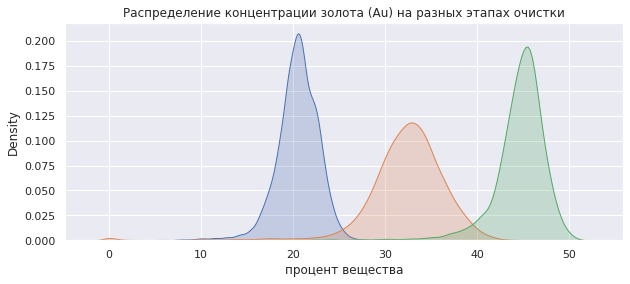

In [39]:
#удалим значения равные нулю и проверим графики

print('df_full', df_full.shape)

df_full = df_full.drop(df_full.loc[df_full['rougher.output.concentrate_au']         <= 0].index)
df_full = df_full.drop(df_full.loc[df_full['primary_cleaner.output.concentrate_au'] <= 0].index)
df_full = df_full.drop(df_full.loc[df_full['final.output.concentrate_au']           <= 0].index)

df_full = df_full.drop(df_full.loc[df_full['rougher.output.concentrate_ag']         <= 0].index)
df_full = df_full.drop(df_full.loc[df_full['primary_cleaner.output.concentrate_ag'] <= 0].index)
df_full = df_full.drop(df_full.loc[df_full['final.output.concentrate_ag']           <= 0].index)

df_full = df_full.drop(df_full.loc[df_full['rougher.output.concentrate_pb']         <= 0].index)
df_full = df_full.drop(df_full.loc[df_full['primary_cleaner.output.concentrate_pb'] <= 0].index)
df_full = df_full.drop(df_full.loc[df_full['final.output.concentrate_pb']           <= 0].index)

print('df_full', df_full.shape)

sns.set(rc={'figure.figsize':(10,4)})
ax = sns.kdeplot(df_full['rougher.output.concentrate_au'], shade=True, label='Флотация' )
ax = sns.kdeplot(df_full['primary_cleaner.output.concentrate_au'], shade=True, label='Первичная очистка' )
ax = sns.kdeplot(df_full['final.output.concentrate_au'], shade=True, label='Финальный продукт' )
plt.title('Распределение концентрации золота (Au) на разных этапах очистки')
plt.xlabel('процент вещества');

## Модель

    Спрогнозируем две величины:
    1.	эффективность обогащения чернового концентрата rougher.output.recovery;
    2.	эффективность обогащения финального концентрата final.output.recovery.

    Итоговая метрика складывается из двух величин:     
    *     sMAPE_total = 0.25 * sMAPE(rougher) + 0.75 * sMAPE(final)

### Напишем функцию для вычисления итоговой sMAPE.

Метрика качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Аналогична MAE, но выражается не в абсолютных величинах, а в относительных. 
Метрика симметричная, т.к она одинаково учитывает масштаб и целевого признака, и предсказания.
Формула метрики sMAPE:

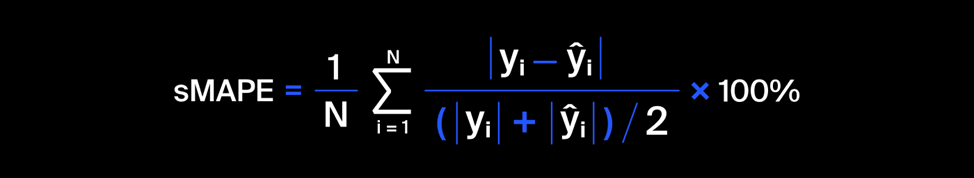

In [40]:
#напишем функцию и проверим ее работу на примере из пункта 1.2
def smape(act,forc):
    return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))

result = smape(df_train['rougher.output.recovery'], df_train['rougher.output.recovery_calculation'])
print("sMAPE :",result)

sMAPE : 1.1598012478556473e-14


#### Подготовим данные для трейн выборки

In [41]:
df_train = df_train.dropna() #удалим пропуски

In [42]:
#cделаем таргеты для обучения модели на трейн выборке
target_train_rougher = df_train['rougher.output.recovery']
target_train_final   = df_train['final.output.recovery']

print('target_train_rougher', target_train_rougher.shape)
print('target_train_final', target_train_final.shape)

target_train_rougher (11017,)
target_train_final (11017,)


In [43]:
print('df_test', df_test.shape)
print('df_train', df_train.shape)

for column in columns_train:
    if column in different_columns:
        df_train = df_train.drop([column], axis=1) #удалим столбцы/признаки (которые мы их нашли в 1.3) в train, сравняем c test

df_train = df_train.drop(['date'], axis=1)
print()        
print('df_test', df_test.shape)
print('df_train', df_train.shape)

#в df_train будет на 1 столбец больше, это столбец rougher.output.recovery который мы сохранили в списке в 1.3

df_test (5229, 52)
df_train (11017, 88)

df_test (5229, 52)
df_train (11017, 53)


In [44]:
#cделаем признаки для обучения модели на трейн выборке
features_train = df_train.drop(['rougher.output.recovery'], axis=1)
print('features_train', features_train.shape)

features_train (11017, 52)


#### Обучим разные модели и оценим их качество кросс-валидацией. 
    Рассчитаем оценки smape 3х моделей и оценку smape DummyRegressor

In [27]:
#получим оценки для 3х моделей на выборке трейн
random_state = 12345
cv = 2
models = [DecisionTreeRegressor(random_state=random_state), 
          RandomForestRegressor(random_state=random_state), 
          LinearRegression()]

results_cross_val = []

for model in models:     
    scorer = make_scorer(smape, greater_is_better=False) 
          
    cross_val_score_rougher = cross_val_score(model, 
                                              features_train, 
                                              target_train_rougher, 
                                              cv=cv, scoring=scorer).mean()
    
    cross_val_score_final = cross_val_score(model, 
                                            features_train, 
                                            target_train_final, 
                                            cv=cv, scoring=scorer).mean()
                                                                                                                                                                          
    results_cross_val.append({'model name'             : model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final'  : cross_val_score_final}) 
              
pd.DataFrame(results_cross_val)

,model name,cross_val_score_rougher,cross_val_score_final
0,DecisionTreeRegressor,-23.626486,-23.301111
1,RandomForestRegressor,-16.475611,-12.480547
2,LinearRegression,-16.563648,-11.265249


#### smape train

In [28]:
#получим оценку smape по трейн выборке, 
#сравнивая дамми предсказание -медиану и столбец 'rougher.output.recovery' в переменной target_train_rougher

dummy_regressor_rougher = DummyRegressor(strategy="median") #выберем модель и стратегию -медиана в качестве константной модели
dummy_regressor_rougher.fit(features_train, target_train_rougher) #обучим

dummy_rougher_pred = dummy_regressor_rougher.predict(features_train) #получим предсказания на основе медианы

smape_dummy_rougher = smape(target_train_rougher, dummy_rougher_pred) #получим оценку через нашу рукописную функцию smape
smape_dummy_rougher

10.472801956400412

In [29]:
#получим оценку smape по трейн выборке, 
#сравнивая дамми предсказание -медиану и столбец 'final.output.recovery' в переменной target_train_rougher

dummy_regressor_rougher = DummyRegressor(strategy="median") #выберем модель и стратегию -медиана в качестве константной модели
dummy_regressor_rougher.fit(features_train, target_train_final) #обучим

dummy_rougher_pred = dummy_regressor_rougher.predict(features_train) #получим предсказания на основе медианы

smape_dummy_final = smape(target_train_final, dummy_rougher_pred) #получим оценку через нашу рукописную функцию smape
smape_dummy_final

9.550327931020822

In [30]:
smape_dummy_total = 0.25 * smape_dummy_rougher + 0.75 * smape_dummy_final
smape_dummy_total

9.780946437365719

### Выберем лучшую модель и проверим её на тестовой выборке (используем формулы метрик качества).

#### Подготовим данные тестовой выборки

In [36]:
features_test = df_test
print('features_test', features_test.shape)
df_test = df_test.dropna() #удалим пропуски

#cделаем таргеты для обучения модели на трейн выборке /// ЭТО ПОНАДОБИТСЯ ПОСЛЕ РАСЧЕТА НИЖЕ
#target_train_rougher = df_train['rougher.output.recovery']
#target_train_final   = df_train['final.output.recovery']
#print('target_train_rougher', target_train_rougher.shape)
#print('target_train_final', target_train_final.shape)

#cделаем признаки для обучения модели на тест выборке

print('features_test', features_test.shape)

features_test (5229, 52)
features_test (5229, 52)


#### Рассчитаем 2 параметра для тестовой выборки

#рассчитаем как в пункте 1.2, и добавим столбцы к test target
#создадим расчетный столбец  rougher.output.recovery
df_test_target_calc = pd.DataFrame()

#внесем данные в расчетный столбец согласно формуле
df_test_target_calc['rougher.output.recovery_calculation'] = (  
    (df_test['rougher.output.concentrate_au']*(df_test['rougher.input.feed_au']-df_test['rougher.output.tail_au'])) / (
        df_test['rougher.input.feed_au']*(df_test['rougher.output.concentrate_au']-df_test['rougher.output.tail_au']))  )*100

KeyError: 'rougher.output.concentrate_au'

In [45]:
#получим столбцы (rougher.output.recovery и final.output.recovery) из full в test через связь с датой, 
df_test_raw = df_test_raw.dropna() #удалим пропуски
df = df_test_raw.merge(df_full_raw, on='date', how='left')
#df.info()
df.shape
#print(x.dtypes)

target_test_rougher = df['rougher.output.recovery']
target_test_final   = df['final.output.recovery']

In [47]:
target_test_rougher

0       89.993421
1       88.089657
2       88.412756
3       87.360133
4       83.236367
5       79.613867
6       79.957839
7       82.183217
8       83.531184
9       78.728035
10      75.811940
11      76.999993
12      75.413838
13      75.497089
14      79.133894
15      83.360777
16      84.680853
17      83.703965
18      77.584848
19      76.004040
20      68.535623
21      75.679131
22      79.271896
23      77.145809
24      77.372574
25      77.245611
26      73.628052
27      78.471515
28      75.541085
29      72.610558
30      82.052806
31      75.771787
32      75.649488
33      71.140582
34      69.398188
35      66.153031
36      65.402279
37      66.660027
38      67.087064
39      76.543976
40      72.113142
41      75.207756
42      77.888780
43      78.987879
44      76.992461
45      74.672975
46      77.319117
47      77.251163
48      73.069471
49      78.247660
50      73.455115
51      72.195025
52      69.554367
53      65.515013
54      61.698112
55      56

#### Спрогнозируем 2 параметра для тестовой выборки

##### rougher

In [65]:
#из опыта предыдущих проектов и тк по оценке -значения с минусами у всех, возьмем RandomForestRegressor

model_rougher = RandomForestRegressor(random_state=12345)
model.fit(features_train, target_train_rougher) # обучим модель
predictions_rougher = model.predict(features_test) # получим предсказания 

##### final

In [66]:
model_final = RandomForestRegressor(random_state=12345)
model.fit(features_train, target_train_final) # обучим модель
predictions_final = model.predict(features_test) # получим предсказания

#### smape test

In [67]:
smape_rougher_test = smape(target_test_rougher, predictions_rougher)
smape_rougher_test

10.322704960621914

In [68]:
smape_final_test = smape(target_test_final, predictions_final)
smape_final_test

8.758788495040482

In [69]:
smape_total_test = 0.25 * smape_rougher_test + 0.75 * smape_final_test
smape_total_test

9.14976761143584

### Вывод
smape_total_test = 9.14976761143584 мы получили ниже чем, smape_dummy_total = 9.780946437365719

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке